In [144]:
import sys 
import os
import numpy as np 
import random
import matplotlib.pyplot as plt

In [145]:
def readFile(n, fileName):
    file = []
    with open (f"config/{fileName}_{n}.txt") as data:
        for row in data:
            file.append(row.replace('\n', ''))
        return file

In [146]:
def interArrivalPlot(interarrival_times):
    plt.hist(interarrival_times, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Simulated Theoretical Distribution')
    plt.xlabel('Interarrival time')
    plt.ylabel('Probability Density')
    plt.grid(True)
    plt.show()

In [147]:
def generate_interArrivals(Lamba, alpha_2l, alpha_2u, endTime):
    cum_time = 0
    interArrivalTime = []

    while True:
        a1k = np.random.exponential(1 / Lamba)
        a2k = np.random.uniform(alpha_2l, alpha_2u)
        ak = a1k * a2k
        cum_time += ak
        if cum_time > endTime:
            break
        interArrivalTime.append(ak)
    return interArrivalTime

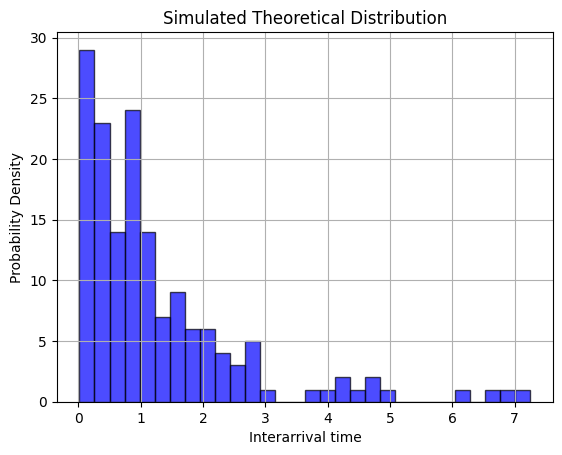

In [148]:
interArrivalFile = readFile(4, 'interarrival')
mode = readFile(4, 'mode')[0]
paraFile = readFile(4, 'para')
serviceFile = readFile(4, 'service')
n = int(paraFile[0])
n0 = int(paraFile[1])
Tlimit = float(paraFile[2])
endTime = int(paraFile[3])
Lamba, alpha_2l, alpha_2u = tuple(float(e) for e in interArrivalFile[0].split())
interArrival = generate_interArrivals(Lamba, alpha_2l, alpha_2u, endTime)
interArrivalPlot(interArrival)

Visual Check: Look at the shape of the histogram. Since you are multiplying two random variables (one from an exponential distribution and one from a uniform distribution), you would expect a skewed distribution with a peak at the lower end, which then tails off. The distribution shape in the histogram should somewhat follow this expected pattern.

In [149]:
def generate_groups(p0, n):
    jobsGroup = []
    for _ in range(n):
        random_number = random.random()
        if random_number < p0:
            jobsGroup.append("0")
        else:
            jobsGroup.append("1")
    return jobsGroup

In [150]:
p0 = 0.7
rounds = 10000
group0_jobs = 0
jobsGroup = generate_groups(p0, rounds)
for j in jobsGroup:
    if j == "0":
        group0_jobs += 1
group0_jobs


6935

Run the Simulation: Run your simulation for a sufficiently large number of jobs. The larger the number, the more accurate your verification will be due to the Law of Large Numbers.

Count the Jobs: Keep count of how many jobs are sent to Group 0 and Group 1.

Calculate Empirical Probabilities: Calculate the empirical probabilities as the counts divided by the total number of jobs.

In [151]:
class job:
    def __init__(self, arrivalTime, serviceTime, group, index):
        self.arrivalTime = arrivalTime
        self.serviceTime = float(serviceTime)
        self.group = group
        self.departureTime = float(arrivalTime) + float(serviceTime)
        self.eventTime = arrivalTime
        self.index = index
        self.type = "Arrival"

def add_to_jobs(jobList, job):
    jobList.append(job)
    jobList.sort(key=lambda x: x.eventTime)

def queue_to_server(queue, jobList, masterclock):
    nextJob = queue.pop(0)
    nextJob.eventTime = masterclock
    add_to_jobs(jobList, nextJob)

def generate_arrivals(Lamba, alpha_2l, alpha_2u, endTime):
    arrivalTime = []

    a1k = np.random.exponential(1 / Lamba)
    a2k = np.random.uniform(alpha_2l, alpha_2u)
    while True:
        if not arrivalTime:
            ak = a1k * a2k
        else:
            ak = arrivalTime[-1] + (a1k * a2k)
        if ak > endTime:
            break
        arrivalTime.append(ak)
    return arrivalTime



In [152]:
def mrt(jobs):
    response_times = {"0":0,"1":0}
    n = {"0":0, "1":0}
    mean = {"0":0, "1":0}
    for arr_time, dep_time, group in jobs:
        if group != "r0":
            mean[group] += (dep_time - arr_time)
            n[group] += 1
            
    response_times["0"] = mean["0"] / n["0"]
    response_times["1"] = mean["1"] / n["1"]

    return response_times

def inverse_cdf0(g, alpha, beta, eta):
    gamma = alpha**(-eta) - beta**(-eta)
    return (eta/(gamma * g)) ** (1/(eta+1))

def inverse_cdf1(g, alpha, eta):
    gamma = alpha**(-eta)
    return (eta/(gamma * g)) ** (1/(eta+1))

def generate_services(alpha0, beta0, eta0, alpha1, eta1, interArrivalTime, jobsGroup):
    serviceTime = []
    rand_values = np.random.uniform(size=len(interArrivalTime))
    for i in range(len(interArrivalTime)):
        if jobsGroup[i] == "0":
            serviceTime.append(inverse_cdf0(rand_values[i], alpha0, beta0, eta0))
        else:
            serviceTime.append(inverse_cdf1(rand_values[i], alpha1, eta1))

    return serviceTime

In [153]:
def output(s, completed_jobs):
    with open(f"output/mrt_{s}.txt", "w") as mrt_file:
                mrt_file.write(f"{mrt(completed_jobs)["0"]} "+ f"{mrt(completed_jobs)["1"]}")

    # Save dep values to a file
    with open(f"output/dep_{s}.txt", "w") as dep_file:
        for l in completed_jobs:
            dep_file.write(" ".join(map(str, l)) + "\n")

def get_all_jobs(mode, interArrivalFile, serviceFile, paraFile):
    arrivalTime = []
    serviceTime = []
    jobsGroup = []

    jobList = []

    if mode == "random":
        endTime = int(paraFile[3])
        Lamba, alpha_2l, alpha_2u = tuple(float(e) for e in interArrivalFile[0].split())
        p0 = float(serviceFile[0])
        alpha0, beta0, eta0  = tuple(float(e) for e in serviceFile[1].split())
        alpha1, eta1  = tuple(float(e) for e in serviceFile[2].split())

        arrivalTime = generate_arrivals(Lamba, alpha_2l, alpha_2u, endTime)
        jobsGroup = generate_groups(p0, len(arrivalTime))
        serviceTime = generate_services(alpha0, beta0, eta0, alpha1, eta1, arrivalTime, jobsGroup)
        
        for i in range(len(arrivalTime)):
            jobList.append(job(arrivalTime[i], serviceTime[i], jobsGroup[i], index=i))
        
        
    return jobList

In [154]:
def get_rt():
    results = []
    
    with open('output/dep_7.txt', 'r') as file:
        for line in file:
            parts = line.split()
            
            arr = float(parts[0])
            dep = float(parts[1])
            
            # Append the difference and the third element to the results list
            if parts[2] != 'r0':
                results.append((dep - arr, parts[2]))
    return results


In [155]:
def main(s, n0):
    interArrivalFile = readFile(s, 'interarrival')
    mode = readFile(s, 'mode')[0]
    paraFile = readFile(s, 'para')
    serviceFile = readFile(s, 'service')

    n = int(paraFile[0])
    n0 = n0
    Tlimit = float(paraFile[2])

    masterclock = 0
    group0 = 0
    group1 = 0
    queue0 = []
    queue1 = []

    completed_jobs = []

    jobList = get_all_jobs(mode, interArrivalFile, serviceFile, paraFile)
    
    while jobList:
        currentJob = jobList.pop(0)
        masterclock = currentJob.eventTime
        if currentJob.type == "Arrival":
            if currentJob.group == "0":
                if group0 != n0:
                    group0 += 1
                    if currentJob.serviceTime > Tlimit:
                        currentJob.departureTime = masterclock + Tlimit
                        currentJob.eventTime = currentJob.departureTime
                        currentJob.group = "R"
                        currentJob.type = "Departure"
                        add_to_jobs(jobList, currentJob)
                    else:
                        currentJob.departureTime = masterclock + currentJob.serviceTime
                        currentJob.eventTime = currentJob.departureTime
                        currentJob.type = "Departure"
                        add_to_jobs(jobList,currentJob)
                else:
                    queue0.append(currentJob)
            elif currentJob.group == "1" or currentJob.group == "r0":
                if group1 != n-n0:
                    group1 += 1
                    currentJob.departureTime = masterclock + currentJob.serviceTime
                    currentJob.eventTime = currentJob.departureTime
                    currentJob.type = "Departure"
                    add_to_jobs(jobList, currentJob)
                else:
                    queue1.append(currentJob)
        elif currentJob.type ==  "Departure":
            if currentJob.group == "0":
                completed_jobs.append((currentJob.arrivalTime, masterclock, currentJob.group))
                if queue0:
                    queue_to_server(queue0, jobList, masterclock)
                group0 -= 1
            elif currentJob.group == "R":
                currentJob.type = "Arrival"
                currentJob.departureTime = masterclock + currentJob.serviceTime
                currentJob.eventTime = masterclock
                currentJob.group = "r0"
                add_to_jobs(jobList, currentJob)
                if queue0:
                    queue_to_server(queue0, jobList, masterclock)
                group0 -= 1
            else:
                completed_jobs.append((currentJob.arrivalTime, masterclock, currentJob.group))
                if queue1:
                    queue_to_server(queue1, jobList, masterclock)
                group1 -= 1
    output(s, completed_jobs)
    return get_rt()

In [178]:
# Put the traces in a numpy array
nsim = 5     # number of simulation
m = 2000   # number of data points in each simulation
response_times = main(7,8)[:m]


In [179]:
def wmrt(response_times):
    sum_0 = 0
    sum_1 = 0
    n_0 = 0
    n_1 = 0
    for rt, group in response_times:
        if group == '0':
            n_0 += 1
            sum_0 += float(rt)
        else:
            n_1 += 1
            sum_1 += float(rt)

    mean_0 = sum_0 / n_0 if n_0 else 0
    mean_1 = sum_1 / n_1 if n_1 else 0

    return 0.83*mean_0 + 0.059*mean_1


Text(0.5, 1.0, 'window size w = 1000')

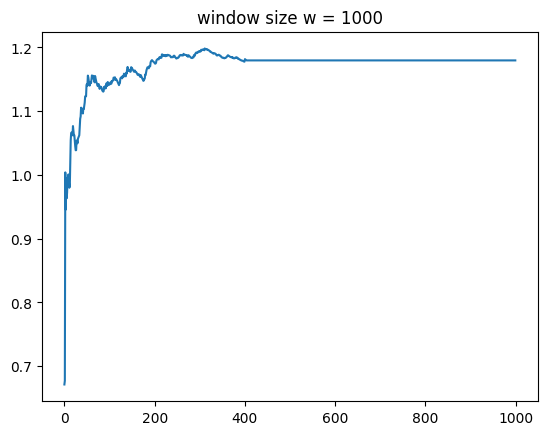

In [180]:
w = 1000
mt_smooth = np.zeros((m-w,))
for i in range(m-w):
    if (i < w):
        mt_smooth[i] = wmrt(response_times[:2*i+1])
    else:
        mt_smooth[i] = wmrt(response_times[(i-w):(i+w)])

plt.plot(np.arange(m-w),mt_smooth)
plt.title('window size w = ' + str(w))

In [159]:
mt_smooth

array([  0.84152456,   0.92917013,   1.0562136 ,   1.0556374 ,
         1.29994274,   1.55928961,   1.55340884,   1.801399  ,
         1.94034074,   2.15368987,   2.35529867,   2.556118  ,
         2.5548173 ,   2.95116256,   3.11814539,   3.34095225,
         3.51081489,   3.70868116,   4.13983987,   4.54395938,
         4.77627179,   5.15501741,   5.5134664 ,   5.70967738,
         5.91040274,   6.31870613,   6.53152843,   6.94380988,
         7.15699776,   7.15991709,   7.15841275,   7.72446049,
         8.00305102,   8.27428481,   8.54276012,   8.79939343,
         9.04558542,   9.53032589,  10.00718876,  10.23963544,
        10.49198166,  10.74328126,  11.00996451,  11.27326416,
        11.80986845,  12.07373625,  12.34190722,  12.60919566,
        12.8717041 ,  13.4516781 ,  14.00067366,  14.28590471,
        14.83800926,  15.37624534,  15.64228189,  15.89896843,
        16.40486306,  16.64997573,  17.1415699 ,  17.15000551,
        17.64018589,  18.12362778,  18.12439561,  18.61